In [2]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
import math as m
import scipy.stats
import seaborn as sns
import matplotlib.cm as cm

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


0.5347530942390941
48.12777848151847


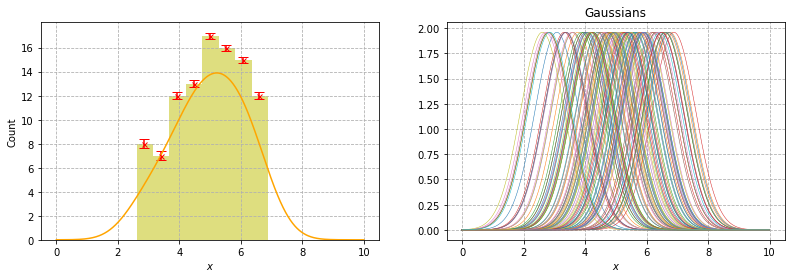

In [20]:
npr.seed(2053854)

#poisson uncert

#1
sig=1.0
mu=5.
x=npr.normal(loc=mu, scale=sig, size=100)

#2
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.3))
p=0.5
histo=ax1.hist(x, bins='auto', alpha=0.5, color='y')
ax1.set_ylabel('Count')
ax1.set_xlabel('$x$')
n=histo[0]
b=[i+p/2 for i in histo[1][:-1]]
n_err=[1/m.sqrt(i) for i in n]
ax1.set_yticks(np.arange(0,int(n.max()),2))
ax1.errorbar(b, n, yerr=n_err, fmt='x', ms=5, c='r', capsize=5)
ax1.grid(linestyle='--')

#3
def gauss(vec,i):
    xi=vec[i]
    s=1.06*vec.std()*len(vec)**(-1/5.)
    x=np.linspace(0, 10,1000)
    y=[]
    for xl in x:
        y.append(1/(s*m.sqrt(2*m.pi))*m.e**(-(xl-xi)**2)/(2*s**2))
    return x, y


#4
y0=np.zeros(1000)

for i in range(len(x)):
    xplot,yplot=gauss(x,i)
    ax2.plot(xplot,yplot, lw=0.5)
    y0=np.sum([y0,yplot], axis=0)

ax2.grid(linestyle='--')
ax2.set_xlabel('$x$')
ax2.set_title('Gaussians')

#5

def trapez(y,x):
    integ=0
    for i in range(1,len(y)):
        integ+=(y[i]+y[i-1])*(x[i]-x[i-1])/2
    return integ


int_gauss=trapez(y0,xplot)
int_histo=trapez(histo[0], histo[1])
print(b[1]-b[0]) #rivedere questo
print(int_histo)

y0=y0*int_histo/int_gauss

ax1.plot(xplot, y0, c='orange')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

Enter the number of categories: 3

 For category 1
 Enter the number of data: 150
 Enter the x of mean: 0
 Enter the y of mean: 0
 Enter var(x): 1
 Enter var(y): 1
 Enter cov(x,y): 0.4

 For category 2
 Enter the number of data: 100
 Enter the x of mean: 0.5
 Enter the y of mean: 2
 Enter var(x): 1
 Enter var(y): 2
 Enter cov(x,y): 1

 For category 3
 Enter the number of data: 200
 Enter the x of mean: 2
 Enter the y of mean: 3
 Enter var(x): 2
 Enter var(y): 2
 Enter cov(x,y): 1


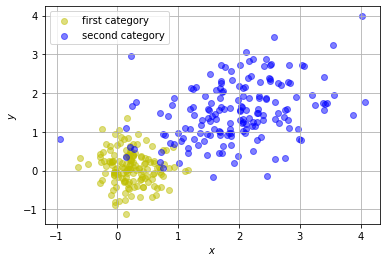

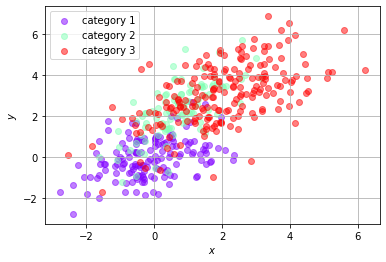

In [49]:
#1
def gauss2d(mu1, sig1, n1, mu2, sig2, n2):

    c1=np.random.multivariate_normal(mu1, sig1, n1).T
    c2=np.random.multivariate_normal(mu2, sig2, n2).T
    return c1[0], c1[1], c2[0], c2[1]

#2

mu1=[0.2, 0.1]
mu2=[2, 1.5]
sig1=[[0.1, 0.01],[0.01, 0.2]]
sig2=[[0.6, 0.2],[0.2, 0.6]]
n1=150
n2=170
                  
x1, y1, x2, y2=gauss2d(mu1, sig1, n1, mu2, sig2, n2)

fig, ax=plt.subplots()

ax.scatter(x1, y1, c='y', alpha=0.5, label='first category')
ax.scatter(x2, y2, c='b', alpha=0.5, label='second category')
ax.legend()
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")


#more general.. da finire

def ngauss2d():
    n=int(input("Enter the number of categories: "))
    fig, ax=plt.subplots()
    ax.grid()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    colors = cm.rainbow(np.linspace(0, 1, n))  
    
    for i,c in zip(range(n), colors):
        print("\n For category {}".format(i+1))
        n1=int(input(" Enter the number of data: "))
        mux=float(input(" Enter the x of mean: "))
        muy=float(input(" Enter the y of mean: "))
        varx=float(input(" Enter var(x): "))
        vary=float(input(" Enter var(y): "))
        covxy=float(input(" Enter cov(x,y): "))
        
        mu=np.array([mux,muy])
        sig=np.array([[varx, covxy],[covxy, vary]])
        gaus=np.random.multivariate_normal(mu, sig, n1).T
        
        
        rgb = (npr.randint(1,255), npr.randint(1,255), npr.randint(1,255))
        ax.scatter(gaus[0], gaus[1],alpha=0.5, color=c, label='category {}'.format(i+1))
    
    ax.legend()

ngauss2d()


--2021-12-09 18:41:42--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2021-12-09 18:41:43--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc9ea214c0b36c72047eae6d13f8.dl.dropboxusercontent.com/cd/0/inline/Bbi86l4xLbokJ6RXkl3VNZjDick--UB7E2XGOF370UhS0RKjFrU1J7Rwe-c2X49ub7uX_s1KV6nznUH2Fk5NH4wcTEx_u_rSYi8APPiSYvqIgR0485i3P6Wbg68SLS08sfkzrm4a4n0hFjzwCaEXQqe2/file# [segue]
--2021-12-09 18:41:43--  https://uc9ea214c0b36c72047eae6d13f8.dl.dropboxusercontent.com/cd/0/inline/Bbi8

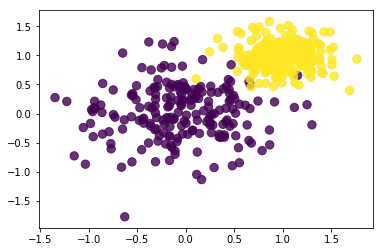

In [4]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [5]:
#1

#!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy -P ~/data/

       residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
2      -7.200000        3.4
3      -4.150000        8.4
4      -6.590000        1.7
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[11131 rows x 2 columns]


<ErrorbarContainer object of 3 artists>

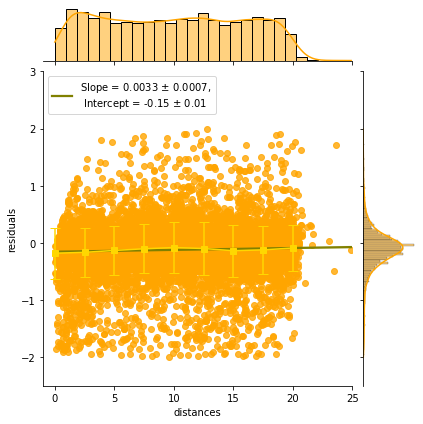

In [52]:
data = np.load("/home/eugenio/data/residuals_261.npy", allow_pickle=True)
df=pd.DataFrame(data.item())
#2
print(df)
#3
df=df[abs(df['residuals'])<2]
#4
linreg = scipy.stats.linregress(df['distances'], df['residuals'])
#5
g=sns.jointplot(x='distances', y='residuals', data=df, kind="reg", color='orange', joint_kws={'line_kws':{'color':'olive'}})
g.ax_joint.set_xlim([-1,25])
g.ax_joint.set_ylim([-2.5,3])
g.ax_joint.legend(loc='upper left', labels=["Slope = {:.4f} $\pm$ {:.4f}, \n Intercept = {:.2f} $\pm$ {:.2f}".format(linreg.slope, linreg.stderr, linreg.intercept, linreg.intercept_stderr)])

#6
x=np.arange(0, 22.5, 2.5)
y=[]
yerr=[]

for i in range(len(x)):
    y.append(df['residuals'][df['distances']<(x[i]+2.5)][df['distances']>(x[i]-2.5)].mean())
    yerr.append(df['residuals'][df['distances']<(x[i]+2.5)][df['distances']>(x[i]-2.5)].std())
    

#7
g.ax_joint.errorbar(x, y, yerr, c='gold', capsize=5, marker='s')
